# Playing with swept linear ramps

Here are two ways to make a linear ramp with a swept starting point.

Normally this is something you'd play at DC, for a bias ramp, but I use RF here so the demo will work without DC-coupled DACs and ADCs.

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from qick.averager_program import QickSweep
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.261
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

## staircase ramp

You can make an arbitrarily long ramp by concatenating square pulses while ramping the gain, but it is going to have steps.

The code for each step compiles to regwi (write the pulse time), set (send the pulse to the generator), mathi (increment the gain). Looking at the state machine in https://github.com/openquantumhardware/qick/blob/main/firmware/ip/axis_tproc64x32_x8_v1/src/ctrl.sv, regwi is 2 ticks, set is 4 ticks, mathi is 5 ticks - 11 ticks total of the tProc clock. You can get rid of the regwi but it only gets you to 9 ticks; on this firmware that's ~13 generator ticks, if your steps are shorter you will eventually get gaps between them.

  0%|          | 0/1 [00:00<?, ?it/s]

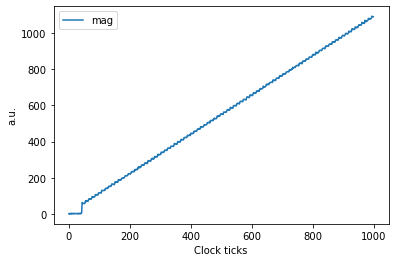

In [3]:
# see how fast we can go
from qick.asm_v1 import QickRegisterManagerMixin
class FastStepsProgram(QickRegisterManagerMixin, AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        res_ch = cfg["res_ch"]
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        freq = self.freq2reg(cfg["pulse_freq"], gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])

        self.set_pulse_registers(ch=res_ch, style="const", freq=freq, phase=0, gain=cfg["g_start"], length=cfg["length"])
        
        self.res_r_gain = self.get_gen_reg(cfg["res_ch"], "gain")
        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])

        for n in range(self.cfg["step_count"]):
#             # default behavior: calculates and sets a new start time for every pulse
#             t = 'auto'

            # set the time register to 0 for first pulse, don't rewrite it for later pulses
            # this saves one regwi per pulse
            # this takes advantage of the fact that the generator will play pulses sequentially if they'd overlap
            t = 0 if n==0 else None
            self.pulse(ch=self.cfg["res_ch"], t=t)
            self.res_r_gain.set_to(self.res_r_gain, "+", self.cfg["step_size"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

config={"res_ch":0, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        "step_count": 100,
        "step_size": 200,
        "g_start": 1000,
        "length":12, # [Clock ticks]
        "readout_length":1000, # [Clock ticks]
        "pulse_freq": 250, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":1
       }

prog =FastStepsProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
iq = iq_list[0]
plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.legend();

  0%|          | 0/1 [00:00<?, ?it/s]

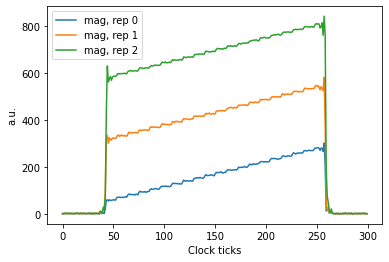

In [4]:
# we can sweep the starting point of the ramp
class SweptStepsProgram(NDAveragerProgram):
    def initialize(self):
        cfg = self.cfg
        res_ch = cfg["res_ch"]
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        freq = self.freq2reg(cfg["pulse_freq"], gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])

        self.set_pulse_registers(ch=res_ch, style="const", freq=freq, phase=0, gain=cfg["g_start"], length=cfg["length"])
        
        self.res_r_gain = self.get_gen_reg(cfg["res_ch"], "gain")
        self.add_sweep(QickSweep(self, self.res_r_gain, cfg["g_start"], cfg["g_stop"], cfg["g_expts"]))

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])

        for n in range(self.cfg["step_count"]):
            t = 0 if n==0 else None
            self.pulse(ch=self.cfg["res_ch"], t=t)
            self.res_r_gain.set_to(self.res_r_gain, "+", self.cfg["step_size"])

        # bring the gain back to where it was before we ramped it
        self.res_r_gain.set_to(self.res_r_gain, "-", self.cfg["step_count"]*self.cfg["step_size"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

config={"res_ch":0, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "pulse_style": "const", # --Fixed
        "step_count": 20,
        "step_size": 200,
        "g_start": 1000,
        "g_stop": 10000,
        "g_expts": 3,
        "length":12, # [Clock ticks]
        "readout_length":300, # [Clock ticks]
        "pulse_freq": 250, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
       }

prog =SweptStepsProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True, soft_avgs=1)
for ii, iq in enumerate(iq_list[0]):
    plt.plot(np.abs(iq[:,0]+1j*iq[:,1]), label="mag, rep %d"%(ii))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.legend();

In [5]:
print(prog)


// Program

                regwi 0, $22, 109226664;        //freq = 109226664
                regwi 0, $23, 0;                //phase = 0
                regwi 0, $25, 1000;             //gain = 1000
                regwi 0, $26, 589836;           //phrst| stdysel | mode | | outsel = 0b01001 | length = 12 
                synci 200;
                regwi 0, $13, 0;
                regwi 0, $14, 0;
LOOP_rep:       regwi 0, $25, 1000;             //'gen0_gain' <= 1000 
                regwi 0, $17, 2;
LOOP_gen0_gain: regwi 0, $16, 16385;            //out = 0b0100000000000001
                seti 7, 0, $16, 100;            //ch =0 out = $16 @t = 0
                seti 7, 0, $0, 110;             //ch =0 out = 0 @t = 0
                regwi 0, $27, 0;                //t = 0
                set 0, 0, $22, $23, $0, $25, $26, $27;//ch = 0, pulse @t = $27
                mathi 0, $25, $25 + 200;        // 'gen0_gain' <= 'gen0_gain' + 200 
                set 0, 0, $22, $23, $0, $25, $26, $27;

## sliding window

A different trick is to make an envelope that's longer than your desired ramp, play only part of it, and slide that window across the envelope. This only works if the long envelope fits in your generator's envelope memory.

  0%|          | 0/1 [00:00<?, ?it/s]

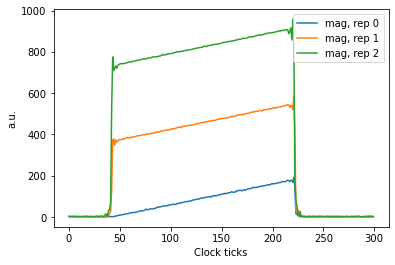

In [6]:
class SlidingWindowProgram(NDAveragerProgram):
    def initialize(self):
        cfg = self.cfg
        res_ch = cfg["res_ch"]
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        freq = self.freq2reg(cfg["pulse_freq"], gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        
        self.add_pulse(ch=cfg['res_ch'], name='ramp', idata=(np.linspace(cfg['g_min'], cfg['g_max'], cfg["total_len"]*16)).astype(int))

        self.set_pulse_registers(ch=res_ch, style="arb", waveform='ramp', freq=freq, phase=0, gain=32000)
        
        truncation = cfg['total_len'] - cfg['window_len']
        
        # shrink the pulse length so we only play part of the envelope we defined
        # you need to know that the pulse length is packed in the bottom 16 bits of the "mode" register:
        # https://github.com/openquantumhardware/qick/blob/e8b3c3be20da0a4b42a6c9463700917b83e3b582/qick_lib/qick/asm_v1.py#L335-L336
        self.res_r_mode = self.get_gen_reg(cfg["res_ch"], "mode")
        self.res_r_mode.set_to(self.res_r_mode, "-", truncation)

        # now we can sweep the start address of the pulse so it slides over the envelope
        self.res_r_addr = self.get_gen_reg(cfg["res_ch"], "addr")
        self.add_sweep(QickSweep(self, self.res_r_addr, 0, truncation, cfg["g_expts"]))

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])

        self.pulse(ch=self.cfg["res_ch"])

        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

config={"res_ch":0, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "pulse_style": "const", # --Fixed
        "window_len": 200,
        "g_min": 0,
        "g_max": 32000,
        "g_expts": 3,
        "total_len":1000, # [Clock ticks]
        "readout_length":300, # [Clock ticks]
        "pulse_freq": 250, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
       }

prog =SlidingWindowProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True, soft_avgs=1)
for ii, iq in enumerate(iq_list[0]):
    plt.plot(np.abs(iq[:,0]+1j*iq[:,1]), label="mag, rep %d"%(ii))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.legend();

In [7]:
print(prog)


// Program

                regwi 0, $22, 109226664;        //freq = 109226664
                regwi 0, $23, 0;                //phase = 0
                regwi 0, $25, 32000;            //gain = 32000
                regwi 0, $24, 0;                //addr = 0
                regwi 0, $26, 525288;           //phrst| stdysel | mode | | outsel = 0b01000 | length = 1000 
                mathi 0, $26, $26 - 800;        // 'gen0_mode' <= 'gen0_mode' - 800 
                synci 200;
                regwi 0, $13, 0;
                regwi 0, $14, 0;
LOOP_rep:       regwi 0, $24, 0;                //'gen0_addr' <= 0 
                regwi 0, $17, 2;
LOOP_gen0_addr: regwi 0, $16, 16385;            //out = 0b0100000000000001
                seti 7, 0, $16, 100;            //ch =0 out = $16 @t = 0
                seti 7, 0, $0, 110;             //ch =0 out = 0 @t = 0
                regwi 0, $27, 0;                //t = 0
                set 0, 0, $22, $23, $24, $25, $26, $27;//ch = 0, pulse @t 